## Содержание <a id="main_title"></a>

1. [Исследование объявлений о продаже квартир](#description_project)
2. [Открытие файлов, описание столбцов](#open_data)
3. [Предъобратка данных](#reprocessing)
  - [Дубли](#duplicates)
  - [Объединение таблиц](#merging)
  - [Работа с пропусками](#isnull)
  - [Изменение типов данных и удаление лишнего](#change_type)
  - [Добавление колонок](#new_columns)
4. [Исследовательский анализ данных](#analyze)
  - [Ежегодные статистики](#yearly_statistics)
  - [Зависимость от возраста](#older_statistics)


## Описание проекта <a id="description_project"></a>

Описание проекта  
Заказчик этого исследования — `Министерство культуры Российской Федерации`.  
Вам нужно изучить рынок российского кинопроката и выявить текущие тренды. Уделите внимание фильмам, которые получили государственную поддержку. Попробуйте ответить на вопрос, насколько такие фильмы интересны зрителю.  
Набор данных содержит информацию о прокатных удостоверениях, сборах и государственной поддержке фильмов, а также информацию с сайта КиноПоиск.

Основные цели проекта:
- Статистика по годам: сколько ежегодно выходит фильмов?
- Найти изменения выручки по годам
- Определить, влияет ли возрастные ограничения на сборы. Меняется ли картинка с годами?
- Исследовать фильмы с гос.поддержкой(окупаемость и рейтинг)

## Открытие файлов, описание столбцов <a id="open_data"></a>

In [239]:
import pandas as pd
df = pd.read_csv('mkrf_movies.csv')
df2 = pd.read_csv('mkrf_shows.csv')

Описание столбцов:
- `title` — название фильма;
- `puNumber` — номер прокатного удостоверения;
- `show_start_date` — дата премьеры фильма;
- `type` — тип фильма;
- `film_studio` — студия-производитель;
- `production_country` — страна-производитель;
- `director` — режиссёр;
- `producer` — продюсер;
- `age_restriction` — возрастная категория;
- `refundable_support` — объём возвратных средств государственной поддержки;
- `nonrefundable_support` — объём невозвратных средств государственной поддержки;
- `financing_source` — источник государственного финансирования;
- `budget` — общий бюджет фильма;
- `ratings` — рейтинг фильма на КиноПоиске;
- `genres` — жанр фильма.
- `box_office` — сборы в рублях. (из второй базы)


[Вернуться к содержанию](#main_title)

## Предъобратка данных <a id="reprocessing"></a>

### Объединение таблиц <a id="merging"></a>

Объединение возможно провести только по номеру прокатного удостоверния. следовательно надо убедиться что значения уникальные

In [240]:
print(len(df[df['puNumber'].duplicated()]))
print(len(df2[df2['puNumber'].duplicated()]))

2
0


In [241]:
# дубликаты есть, но всего парочка... кикаем
df.drop_duplicates(subset='puNumber', inplace=True)

In [242]:
# При первой попытке объединить выдал ошибку, разные типы, при попытке перевести в int, выдал оишбку на "нет":
df = df.query('puNumber != "нет"')
df['puNumber'] = df['puNumber'].astype(int)
df = df.merge(df2, on='puNumber', how='outer')

In [243]:
del df2 # Удаляем, чтоб глаза не мазолила в пространстве имен

[Вернуться к содержанию](#main_title)

### Дубли <a id="duplicates"></a>

In [244]:
# Пробежав глазами, видно дубли по названиям... 2разных фильма с одним названием бывают, 
# а вот чтоб 1 режиссер снял 2фильма с одним названием: нонсанс, поэтому удаляем как удаляем
df.drop_duplicates(subset=['title','director'],inplace=True)


[Вернуться к содержанию](#main_title)

### Работа с пропусками <a id="isnull"></a>

In [245]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6801 entries, 0 to 7482
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  6801 non-null   object 
 1   puNumber               6801 non-null   int32  
 2   show_start_date        6801 non-null   object 
 3   type                   6801 non-null   object 
 4   film_studio            6784 non-null   object 
 5   production_country     6799 non-null   object 
 6   director               6792 non-null   object 
 7   producer               6242 non-null   object 
 8   age_restriction        6801 non-null   object 
 9   refundable_support     331 non-null    float64
 10  nonrefundable_support  331 non-null    float64
 11  budget                 331 non-null    float64
 12  financing_source       331 non-null    object 
 13  ratings                5843 non-null   object 
 14  genres                 5834 non-null   object 
 15  box_

|Название столбца|Что будем с делать с пропусками|
|-----------------------|------------------------------------------------|
|`film_studio`| в исследовании не участвует(оставим NaN)|
|`production_country`| всего пару пропусков - удалим значения|
|`director`| в исследовании не участвует(можно удалить, но зачем то просят выделить фамилию)|
|`producer`| в исследовании не участвует(можно удалить)|
|`refundable_support`| пропуски заполним нулями*|
|`nonrefundable_support`| пропуски заполним нулями|
|`budget`| сначало не будем трогать, как до момента бюджета доберемся, уберем все строки с NaN значениями|
|`financing_source`| поставим значение "Без госсподержки"|
|`ratings`| Значение важное и с бухты-барахты поставить нельзя. удаляем довольно большое кол-во строк|
|`genres`| Оставим пропуски данных|
|`box_office`| Оставим пропуски данных|

*Столбцы связанные с гос.бюджетом NaN заполним нулями, т.к. скорее всего это связано с тем что поддержки не было или фильм забугорный и данных об этом нет, в исследовании по гос.поддержки, забугорные фильмы выкинем все равно и будем смотреть только российские


In [246]:
df.dropna(subset=['production_country'], inplace=True)
df.dropna(subset=['ratings'], inplace=True)
df['refundable_support'].fillna(0, inplace=True)
df['nonrefundable_support'].fillna(0, inplace=True)
df['financing_source'].fillna('Без госсподдержки', inplace=True)


[Вернуться к содержанию](#main_title)

### Изменение типов данных и удаление лишнего <a id="change_type"></a>

In [247]:
df['type'].value_counts()

Художественный                3716
 Художественный               1219
Анимационный                   514
Прочие                         197
Документальный                 159
Научно-популярный               34
 Анимационный                    1
Музыкально-развлекательный       1
Name: type, dtype: int64

In [248]:
change_types = {
    ' Художественный' : 'Художественный',
    'Научно-популярный' : 'Прочие',
    'Музыкально-развлекательный' : 'Прочие',
    ' Анимационный' : 'Анимационный',
}
df['type'] = df['type'].replace(change_types)
del change_types

In [249]:
df['show_start_date'] = pd.to_datetime(df['show_start_date'], format='%Y-%m-%dT%H:%M:%S').dt.round('1d')
df['year'] = df['show_start_date'].dt.year

In [250]:
# Вообщем нам больше столбец show_start_date и нужен...
df.drop(columns=['show_start_date', 'producer'], inplace=True)

In [251]:
df['production_country'].value_counts()

США                                                                    1716
Россия                                                                 1284
СССР                                                                    329
Франция                                                                 266
Великобритания                                                          174
                                                                       ... 
КНР - Сингапур                                                            1
Франция - Бельгия - Великобритания - США - Нидерланды - Канада            1
США - Россия - Польша - Германия - Пуэрто Рико                            1
Франция - Бельгия - Канада                                                1
Дания - Канада - Швеция - Франция - Германия - Великобритания - США       1
Name: production_country, Length: 873, dtype: int64

In [252]:
df['genres'].value_counts()

драма                           454
комедия                         330
мелодрама,комедия               181
драма,мелодрама                 170
драма,мелодрама,комедия         168
                               ... 
мелодрама,приключения,боевик      1
комедия,криминал,биография        1
комедия,приключения,история       1
боевик,драма,вестерн              1
мелодрама,история,драма           1
Name: genres, Length: 742, dtype: int64

[Вернуться к содержанию](#main_title)

### Добавления колонок <a id="new_columns"></a>

In [253]:
def extraction_genre(row):
    try:
        row = row.split(',')
        return row[0]
    except:
        return None

# Проверка работоспособности функции
print(extraction_genre('мелодрама'))
print(extraction_genre(None))
print(extraction_genre('мелодрама, драма'))

мелодрама
None
мелодрама


In [254]:
df['main_genre'] = df['genres'].apply(extraction_genre)

In [256]:
# Сразу переименовываем жанры которые редко встречаются.
check_genre = df['main_genre'].value_counts()
df['main_genre'].fillna('неизвестно', inplace=True)
df['main_genre'] = df['main_genre'].apply(
    lambda row: 'другой' if check_genre[row] < 100 else row)
del check_genre
df.drop(columns=['genres'], inplace=True)


In [257]:
df['director'].value_counts()

Вуди Аллен                                           13
Стивен Содерберг                                     12
Ридли Скотт                                          11
Л.Гайдай                                             10
Люк Бессон                                           10
                                                     ..
А.Ананикян, В.Рейнгеверц                              1
Е.Салабай, Е.Шабанова, А.Соколов, И.Пшонкин и др.     1
К.Белевич                                             1
В.Крючков                                             1
И.Трусов                                              1
Name: director, Length: 4150, dtype: int64

In [258]:
df['director'] = df['director'].fillna('неизвестен')

In [259]:
def extraction_director(row):
    row = row.split()
    if '.' in row[0]:
        return row[0]
    if len(row) == 1:
        return row[0]
    if len(row) >= 2:
        return ' '.join(row[:2])
    return row
    
print(extraction_director('Е.Салабай, Е.Шабанова, А.Соколов, И.Пшонкин'))
print(extraction_director('Ридли Скотт'))
print(extraction_director('Люк'))
df['correct_director'] = df['director'].apply(extraction_director)
df.drop(columns=['director'], inplace=True)

Е.Салабай,
Ридли Скотт
Люк


In [260]:
df['part_of_state_budget'] = (df['nonrefundable_support'] + df['refundable_support']) / df['budget']
# При деление на ноль возникает inf(бесконечность)... стоит от нее избавиться
df =  df.query('part_of_state_budget != inf')

[Вернуться к содержанию](#main_title)

#### Вывод по обработке:
Удалены столбцы которые не нужны будут в дальнейшем, в категориальных переменных проблема, в том что есть записи из разряда `Россия - Бельгия - Польша`
такая же история со студиями. Студии можно проигнорировать, а вот страны надо будет лемматизировать и доставать Россию.
Добавлены столбцы согласно ТЗ

[Вернуться к содержанию](#main_title)

## Исследовательский анализ данных <a id="analyze"></a>

### Ежегодная статистка <a id="yearly_statistics"></a>

<AxesSubplot:xlabel='year'>

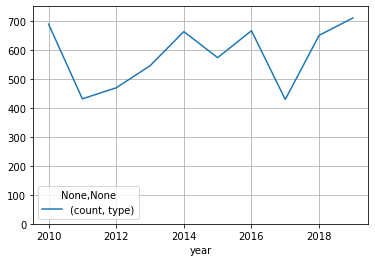

In [261]:
# Добавил ограничения по y с нуля, иначе очень нерепрезентативно было... 
df.pivot_table(index='year', values=['type'], aggfunc=['count']).plot(grid=True, ylim=(0,750))


In [288]:
df[df['box_office'].notna()].pivot_table(
    index='year', values='box_office', aggfunc=['mean', 'median', 'count', 'sum'])


,mean,median,count,sum
,box_office,box_office,box_office,box_office
year,,,,
2010,2.780112e+04,1.916000e+03,85,2.363095e+06
2011,2.041113e+04,3.085000e+03,93,1.898235e+06
2012,5.792805e+04,6.692500e+03,110,6.372086e+06
2013,1.713824e+05,3.550000e+03,173,2.964916e+07
2014,3.014374e+07,1.919000e+04,240,7.234496e+09
2015,7.832065e+07,4.890556e+06,380,2.976185e+10
2016,9.257830e+07,4.572892e+06,438,4.054930e+10
2017,1.390181e+08,1.049589e+07,331,4.601500e+10


Набюдается довольно отчетливые рост в общей выручке и кол-во снимаемых фильмов. Однако стоит отметить, начиная с 2018года средняя и медианные выручки начали падать(при этом медиала в 2019 упала практически в 2раза по сравнению с предществующим годом), это говорит о том, вышло несколько кассовых фильмов, которые компенсировали "ситуацию по больнице". 
Интересно, что для фильмов, у которых выручка неизвестна, кол-во фильмов примерно на одном уровне. но на самом деле если приглядется к первоисточникам, то данные явно имеют очень большое кол-во ошибок(фильмы СССР например относятся к 2014году)

<AxesSubplot:>

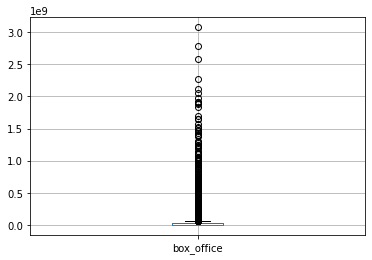

In [294]:
df.boxplot('box_office')

[Вернуться к содержанию](#main_title)

### Зависимость от возвраста <a id="older_statistics"></a>

In [277]:
# Такой вот "костыль" чтоб сортировалось по возрастам в сводной таблице
df['age_restriction'] = df['age_restriction'].replace('«6+» - для детей старше 6 лет', '«06+» - для детей старше 6 лет')

In [292]:
df[df['box_office'].notna()].pivot_table(
    index='age_restriction', values=['box_office'], aggfunc=['mean', 'median', 'sum', 'count']
)


,mean,median,sum,count
,box_office,box_office,box_office,box_office
age_restriction,,,,
«0+» - для любой зрительской аудитории,5.642910e+06,40432.50,9.141515e+08,162
«06+» - для детей старше 6 лет,1.578262e+08,6903398.50,5.350308e+10,339
«12+» - для детей старше 12 лет,1.219177e+08,1022685.50,5.791092e+10,475
«16+» - для детей старше 16 лет,6.685048e+07,1806958.00,6.551347e+10,980
«18+» - запрещено для детей,4.769208e+07,5335160.75,3.863059e+10,810


Больше фильмов снимают для категории 16+. Д

[Вернуться к содержанию](#main_title)